In [9]:
import pandas as pd
from scipy import stats

from src.vizualization import VibrationPlots
from src.statistical import StatisticalAnalysis

import ipywidgets as widgets

In [2]:
df_raw: pd.DataFrame = pd.read_csv(
    'data/processed_data.csv',
    parse_dates=["Time"],
    index_col=[0],
    sep=';'
)

# Drop rows where 'Vibration' column has NaN values
df = df_raw.dropna(subset=['feature']).copy()

threshold = 1500
df_clean = df[df['Corrente motor'] > threshold]

# Add Z-score
df_clean['z_score'] = stats.zscore(df_clean['feature'])

/tmp/ipykernel_9594/2161093257.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['z_score'] = stats.zscore(df_clean['feature'])


In [3]:
df_clean.head()

,feature,Alimentação BU,Alimentação BS,CEEE,% Clínquer,% Gesso mineral,% Gesso sintético,% calcário,% pó filler,% escória,...,Camada - R4,Camada - R5,Camada - R6,Pressão - R1,Pressão - R2,Pressão - R3,Pressão - R4,Pressão - R5,Pressão - R6,z_score
Time,,,,,,,,,,,,,,,,,,,,,
2023-08-01 00:00:00,1.087224,383.878707,376.045112,47.044888,61.066700,3.224712,0.0,4.026222,4.084743,27.597630,...,26.054410,39.925930,11.886000,0.347222,0.347222,0.000000,0.0,3.3,0.173611,-0.618202
2023-08-01 00:01:00,1.087224,383.878720,376.045121,47.044886,61.066697,3.224712,0.0,4.026222,4.084743,27.597626,...,26.054413,39.925934,11.886002,0.347222,0.347222,0.000000,0.0,3.3,0.173611,-0.618200
2023-08-01 00:02:00,1.087224,383.878707,376.045112,47.153918,61.066700,3.224712,0.0,4.026222,4.084743,27.597630,...,26.054410,39.925930,11.886000,0.347222,0.347222,0.000000,0.0,3.3,0.173611,-0.618202
2023-08-01 00:03:00,1.035019,383.334540,375.493164,45.928932,60.960620,3.218622,0.0,4.044761,4.110132,27.665860,...,27.139470,35.947330,12.971070,0.347222,0.347222,0.173611,0.0,3.3,0.173611,-0.888913
2023-08-01 00:04:00,1.035019,383.334515,375.493134,45.928936,60.960623,3.218623,0.0,4.044762,4.110132,27.665861,...,27.139465,35.947327,12.971069,0.347222,0.347222,0.173611,0.0,3.3,0.173611,-0.888911


In [5]:
# Verify null values
df_clean.isnull().sum()

feature             0
Alimentação BU    156
Alimentação BS    141
CEEE               45
% Clínquer        279
                 ... 
Pressão - R3       39
Pressão - R4       39
Pressão - R5       39
Pressão - R6        9
z_score             0
Length: 71, dtype: int64

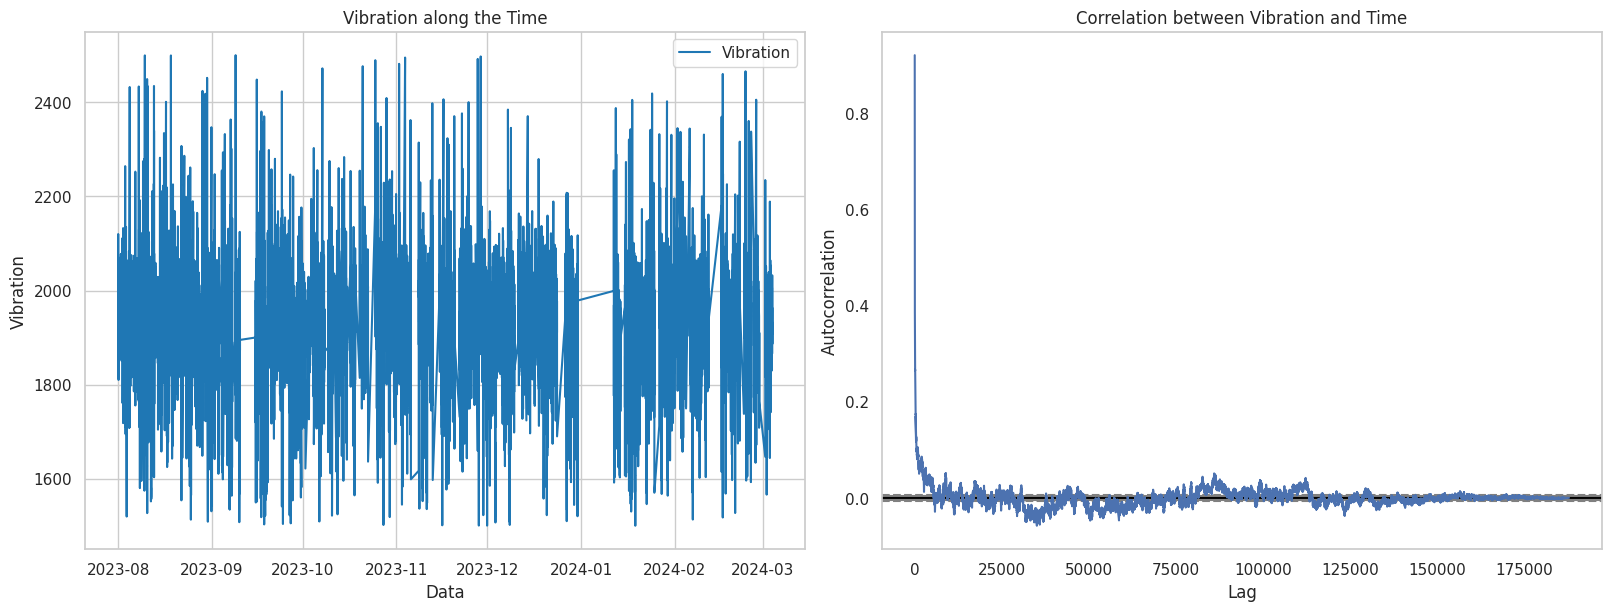

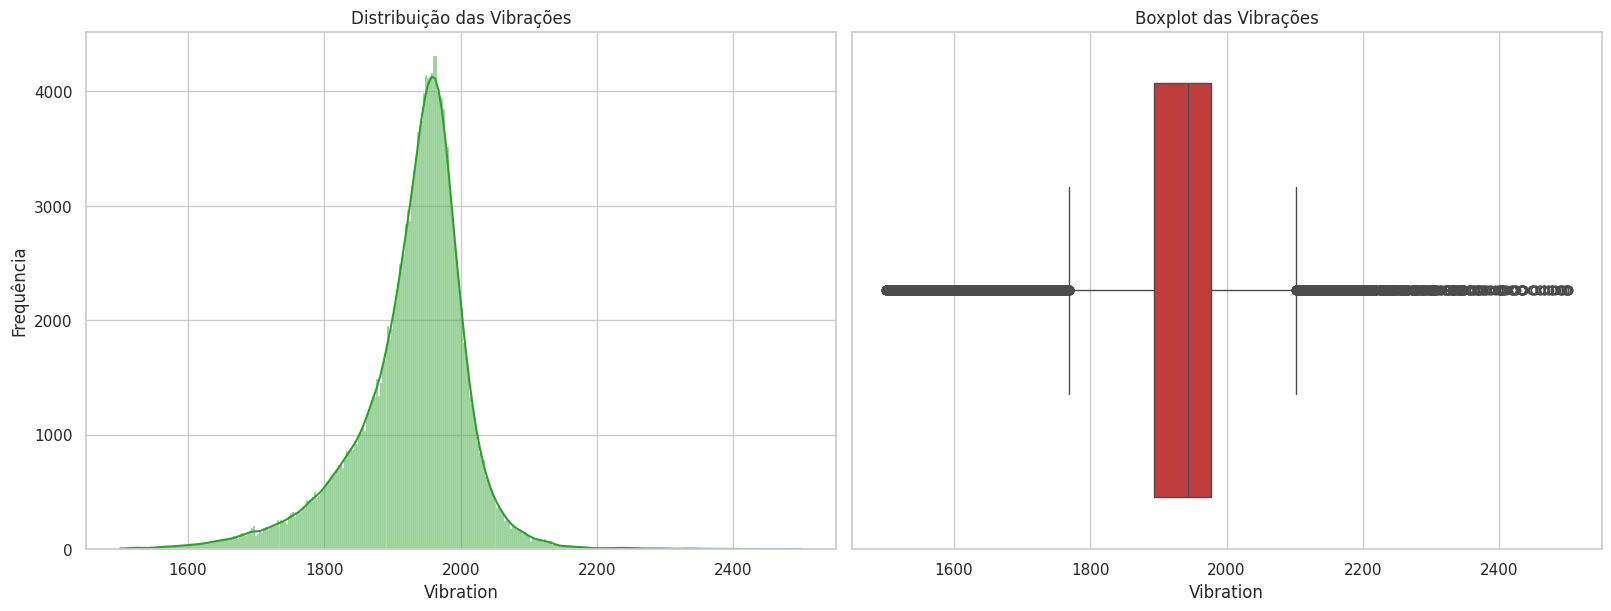

In [7]:
plot_motor = VibrationPlots(df_clean, target='Corrente motor')
plot_motor.general()
plot_motor.hist_and_box()

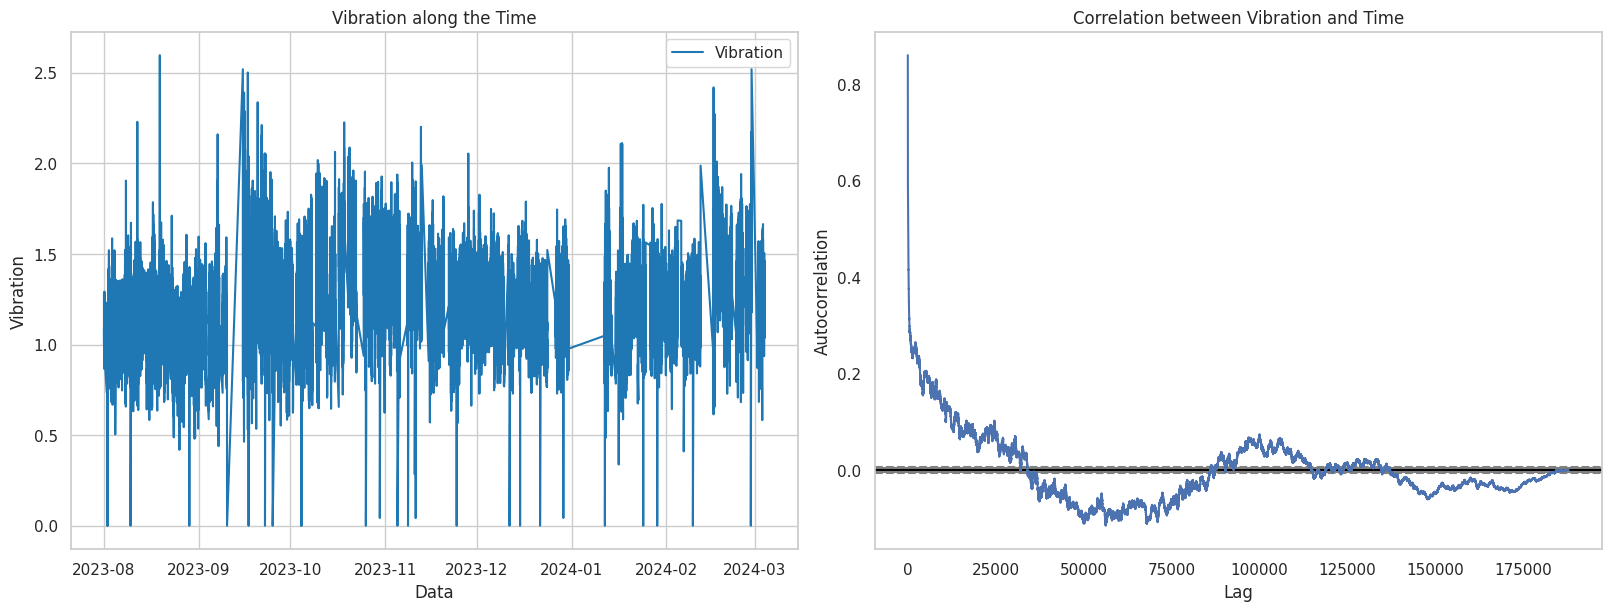

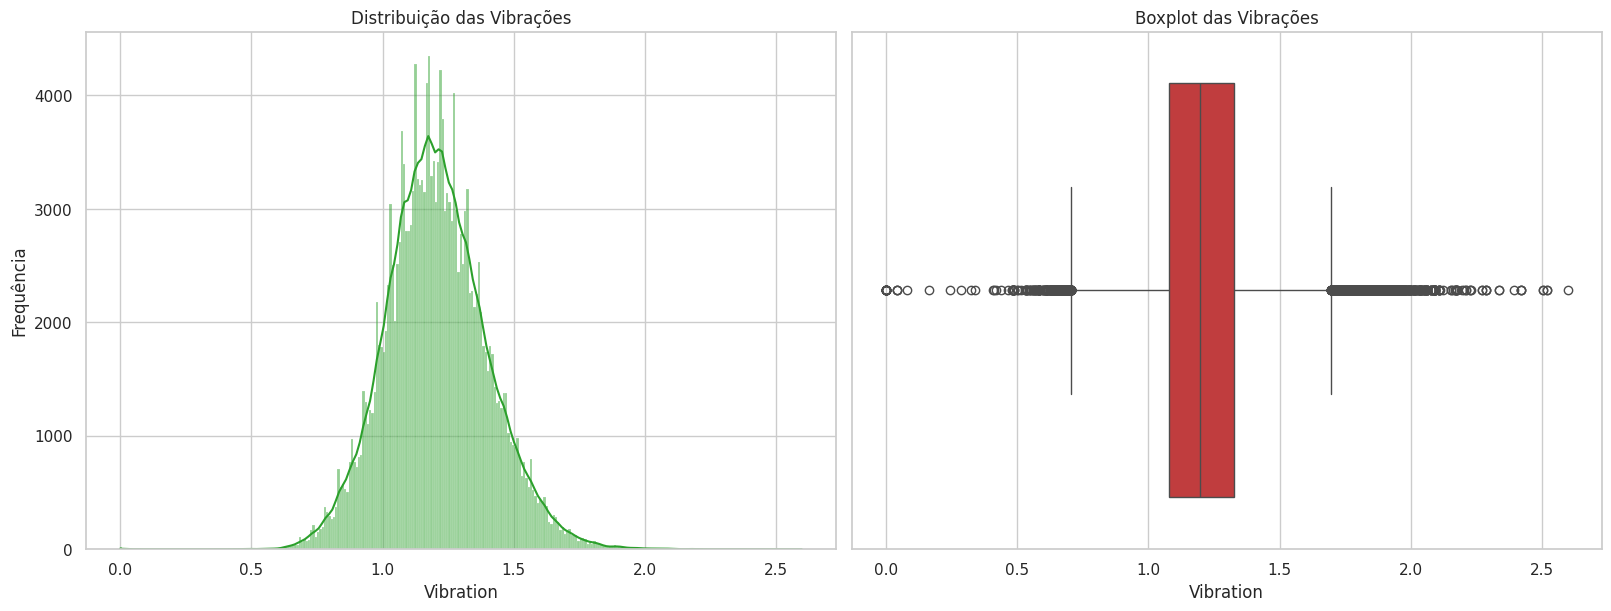

In [6]:
plot = VibrationPlots(df_clean, target='feature')
plot.general()
plot.hist_and_box()

In [7]:
# Count the number of outliers
def count_outliers(df: pd.DataFrame):
    return df[df['z_score'] > 3].shape[0]

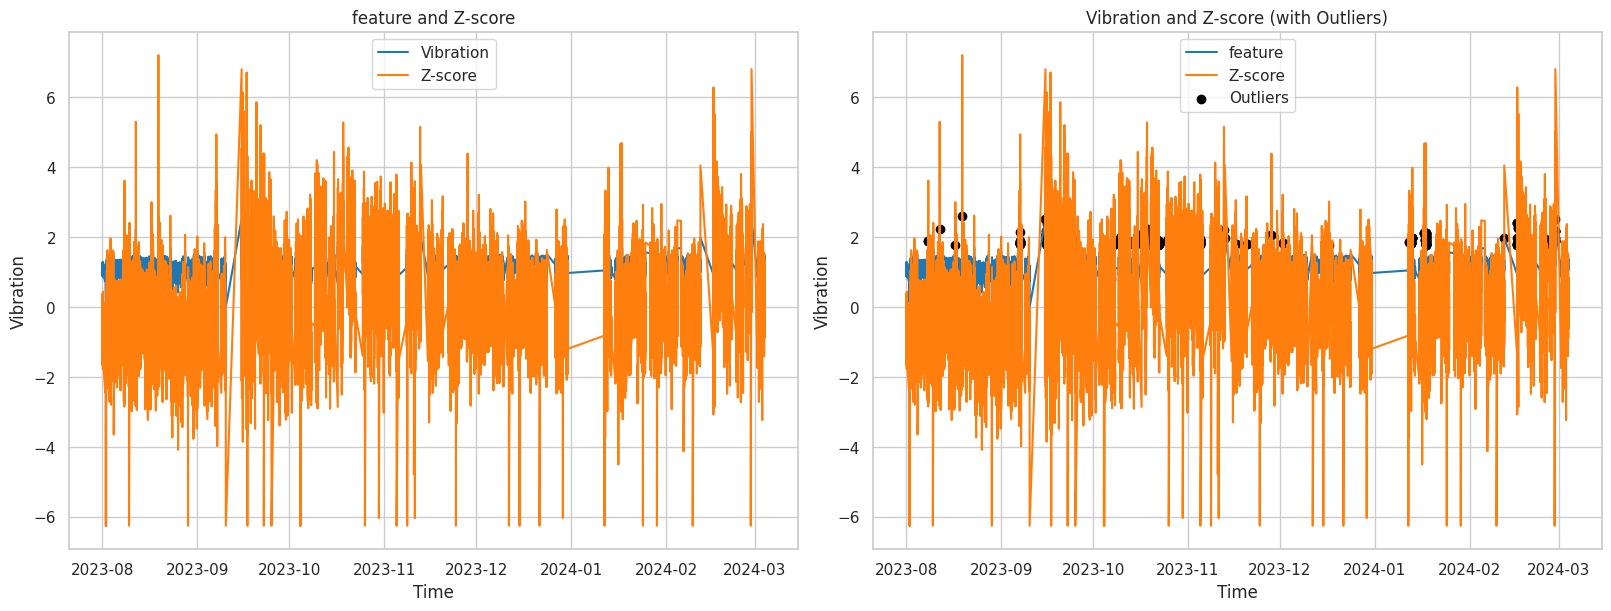

Número de outliers: 786
Número de amostras: 187985
Porcentagem de outliers: 0.42%


In [8]:
plot.z_score()
print(f'Número de outliers: {count_outliers(df_clean)}')
print(f'Número de amostras: {df_clean.shape[0]}')
print(f'Porcentagem de outliers: {count_outliers(df_clean) / df_clean.shape[0] * 100:.2f}%')

### **Análise Outliers**

---

#### **1. Z-Score**
- A linha vermelha, que mostra o Z-score, apresenta vários picos acima e abaixo de **±3**, o que indica outliers significativos, porém alguns influenciados por momentos normais de processo, como paradas planejadas.
- A porcentagem de outliers é de 3% do total de amostras presentes.

In [11]:
analysis = StatisticalAnalysis(df_clean, 'feature')
analysis.perform_analysis()

+-------------+---------------+
| Statistic   |         Value |
+=============+===============+
| count       | 187985        |
+-------------+---------------+
| mean        |      1.20644  |
+-------------+---------------+
| std         |      0.192844 |
+-------------+---------------+
| min         |      0        |
+-------------+---------------+
| 25%         |      1.0775   |
+-------------+---------------+
| 50%         |      1.19779  |
+-------------+---------------+
| 75%         |      1.32523  |
+-------------+---------------+
| max         |      2.59663  |
+-------------+---------------+
+--------------------------+----------+
| Statistic                |    Value |
+==========================+==========+
| Coefficient of Variation | 0.159845 |
+--------------------------+----------+
+-------------+----------+
| Statistic   |    Value |
+=============+==========+
| Skewness    | 0.254275 |
+-------------+----------+
| Kurtosis    | 0.731242 |
+-------------+----------+
+--

### **Análise Estatística dos Dados de Vibração**

---

#### **1. Estatísticas Descritivas**
- **Contagem (count):** 194.557 observações, um número significativo de dados coletados minuto a minuto ao longo de 6 meses.
- **Média (mean):** **1.1738**. A vibração média gira em torno desse valor.
- **Desvio Padrão (std):** **0.2644**. A dispersão dos dados em torno da média é moderada.
- **Mínimo (min):** **0.0**. Valores zerados podem indicar paradas ou falhas na medição.
- **Percentis (25%, 50%, 75%):**
   - **25%:** 1.0655  
   - **Mediana (50%):** 1.1897  
   - **75%:** 1.3207  
   - A distribuição dos dados está **levemente concentrada acima de 1.0**, o que significa que a maior parte dos valores é relativamente próxima da média.
- **Máximo (max):** **3.1553**. Existem valores extremos que representam picos de vibração.

---

#### **2. Coeficiente de Variação (CV):**
- O CV é calculado como a razão entre o desvio padrão e a média:
  \[
  CV = \frac{\text{Desvio Padrão}}{\text{Média}} = 0.225
  \]
- **Interpretação:**
   - Um coeficiente de variação de **0.225 (22,5%)** indica uma **variabilidade moderada** nos dados em relação à média.
   - Isso sugere que, apesar da presença de outliers e variações, os valores de vibração não têm dispersão extrema.

---

#### **3. Assimetria (Skewness):**
- **Skewness = -1.60** (valor negativo):
   - A distribuição é **negativamente assimétrica**, ou seja, a cauda esquerda da distribuição é mais longa.
   - Isso indica que existem **valores mais baixos** de vibração (próximos a zero), possivelmente associados a:
     - **Paradas do equipamento**.
     - **Reduções temporárias** na operação.
   - A concentração maior de valores está acima de **1.0**, com raros valores baixos (outliers para a esquerda).

---

#### **4. Curtose:**
- **Curtose = 6.04**:
   - A curtose indica que a distribuição é **leptocúrtica**, ou seja, possui **caudas longas e picos mais elevados** do que uma distribuição normal.
   - Isso sugere a presença de **outliers**, tanto na parte inferior (valores próximos de 0) quanto superior (picos de vibração).

---

#### **5. Análise Geral**
- A distribuição dos dados de vibração é **moderadamente concentrada**, com uma **média de 1.17** e **baixa dispersão** (CV de 22,5%).
- **Assimetria negativa** e **alta curtose** sugerem:
   - **Presença de valores zerados**, possivelmente indicando **falhas** ou **paradas** no sistema.
   - Picos de vibração fora do padrão.
- O comportamento geral sugere que, na maior parte do tempo, os valores de vibração oscilam próximos à média, mas há momentos específicos em que ocorrem **quedas abruptas ou aumentos extremos**.

---

#### **Conclusões**
1. **Análise de Outliers:**
   - Identificar os períodos onde os valores se aproximam de zero e correlacioná-los com registros operacionais.
   - Analisar os valores máximos para entender possíveis **sobrecargas** ou condições críticas do equipamento.

2. **Segmentação Temporal:**
   - Dividir os dados por períodos (ex.: diários ou semanais) para entender o comportamento da sazonalidade mais claramente.
   - Comparar horários e dias específicos para correlacionar com picos e quedas.

3. **Modelagem Preditiva:**
   - A alta curtose e a assimetria sugerem que modelos tradicionais (como regressão linear) podem não capturar bem esses padrões.
   - Modelos como **LSTM**, SARIMA ou técnicas baseadas em **detectores de anomalia** (ex.: Isolation Forest) podem ser usados para prever vibrações e detectar comportamentos anormais.

---


/home/ezequiel/Projects/vrm-lstm/src/vizualization.py:110: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


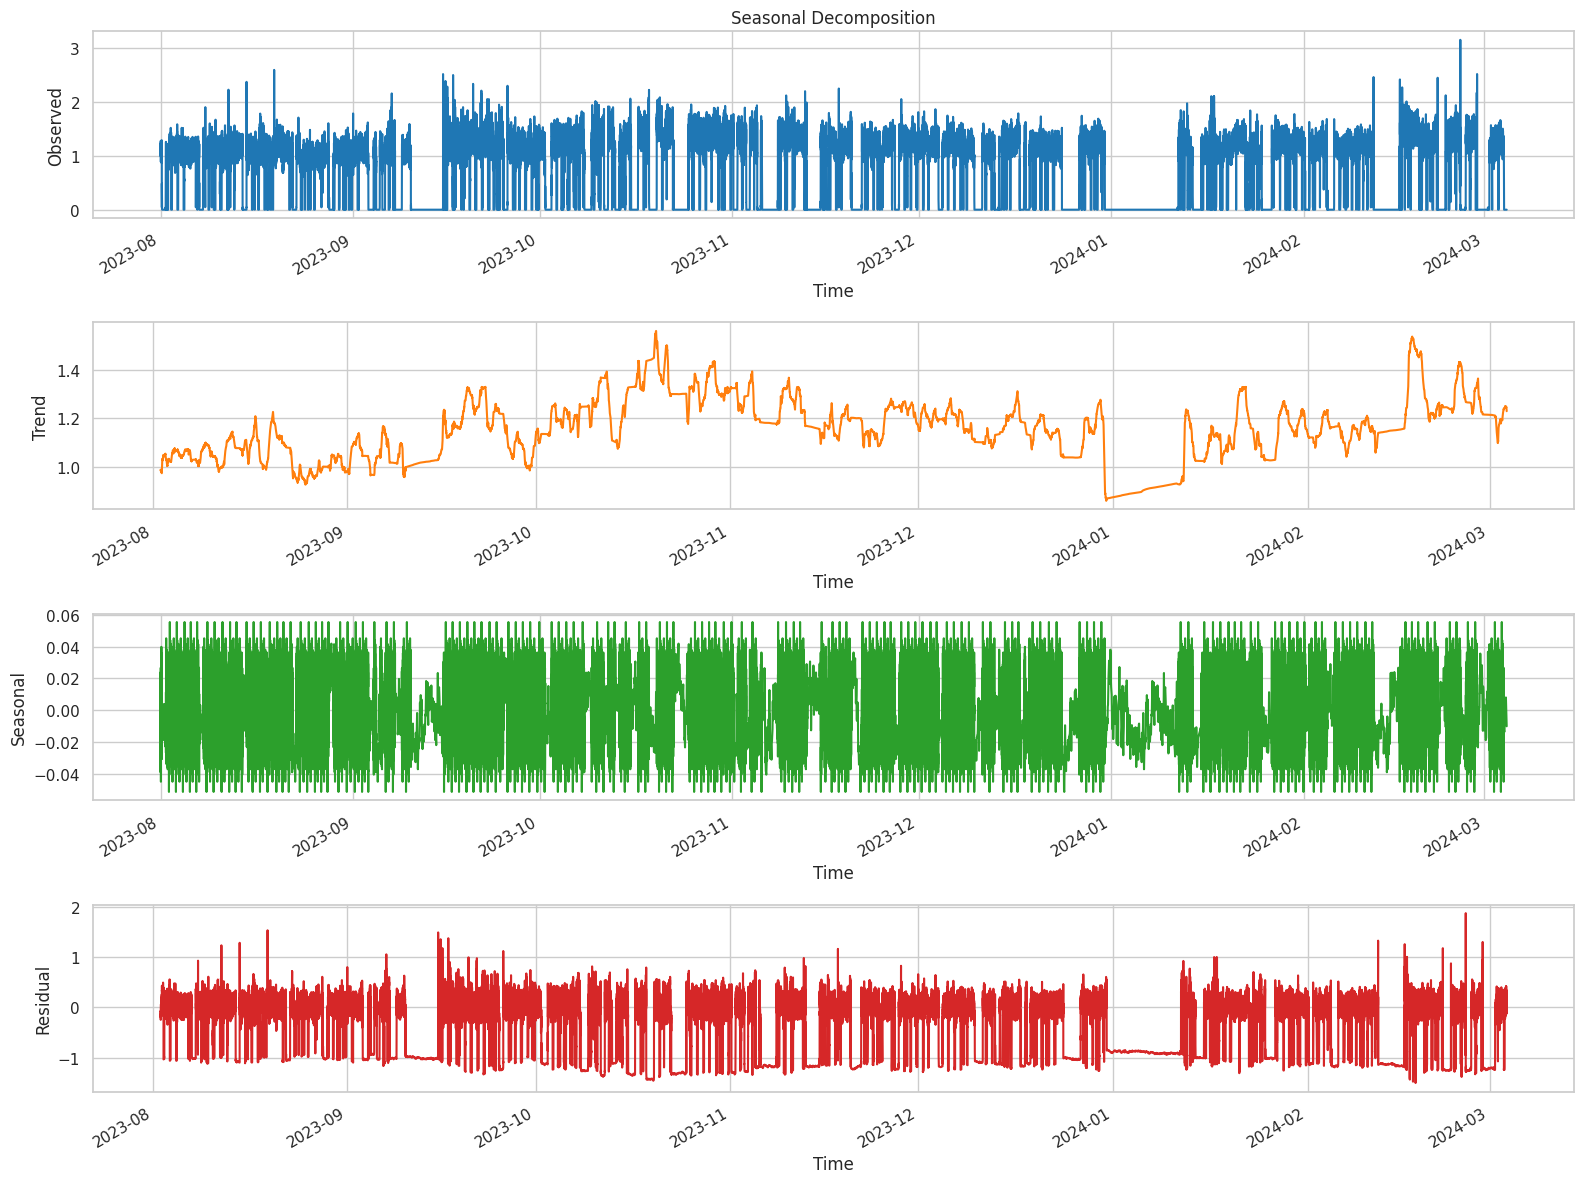

In [8]:
plot.seasonal_decompose()

### **Análise da Decomposição Sazonal (Seasonal Decompose)**

---

#### **1. Gráfico Geral**
O gráfico gerado pelo `seasonal_decompose` foi dividido em quatro componentes principais:

1. **Série Original (feature):**
   - Representa os valores brutos da série temporal de vibração, registrados **minuto a minuto** durante **8 meses**.
   - A série apresenta uma grande quantidade de oscilações e ruído, mas com padrões visíveis de períodos de estabilidade e instabilidade.

2. **Tendência (Trend):**
   - A **tendência** captura o comportamento de longo prazo dos dados.
   - Observações:
     - Há um crescimento gradual na tendência até meados de 2023-11, seguido de períodos de estabilização.
     - Pequenas quedas bruscas indicam **anomalias** ou **falhas temporárias**, possivelmente associadas a paradas ou intervenções no processo.
     - O aumento recente sugere **picos de vibração recorrentes** no final da série, indicando uma possível mudança nas operações do equipamento.

3. **Sazonalidade (Seasonal):**
   - A **componente sazonal** evidencia **oscilações periódicas** nos dados, capturando padrões de curto prazo.
   - Com um **período de 1440 minutos** (equivalente a 1 dia), observa-se:
     - Um **padrão diário consistente**, onde os valores de vibração oscilam de forma **regular**.
     - Algumas alterações no padrão sazonal ao longo do tempo podem indicar variações no comportamento diário do processo.

4. **Resíduos (Residual):**
   - Os **resíduos** representam os valores que **não foram explicados** pela tendência ou sazonalidade.
   - Observações:
     - A presença de **picos positivos e negativos** sugere **anomalias** ou ruídos nos dados.
     - Resíduos mais acentuados podem estar associados a eventos **incomuns**, como falhas de equipamento, paradas inesperadas ou mudanças bruscas no processo.
     - Em vários momentos, os resíduos mostram **clusters de pontos fora do padrão**, indicando que há variações não capturadas pelos componentes anteriores.

---

#### **2. Interpretação**
A decomposição sazonal revelou os seguintes pontos-chave:
1. **Tendência Ascendente com Oscilações:**
   - A tendência geral dos dados sugere um **aumento gradativo** nos valores de vibração ao longo do tempo.
   - Isso pode estar relacionado a mudanças no funcionamento do equipamento, desgaste ou alterações no processo operacional.

2. **Sazonalidade Diária:**
   - Os dados possuem um **comportamento cíclico diário** (período = 1440 minutos), o que indica padrões regulares de vibração ao longo do dia.
   - Qualquer desvio significativo desse padrão sazonal pode ser **sinal de anomalias** ou **mudanças no processo**.

3. **Resíduos e Anomalias:**
   - Os resíduos exibem **variações significativas**, sugerindo que nem toda a variabilidade dos dados foi explicada pela decomposição.
   - Eventos pontuais, como **picos de vibração ou quedas abruptas**, devem ser analisados com cuidado para entender suas causas.

---


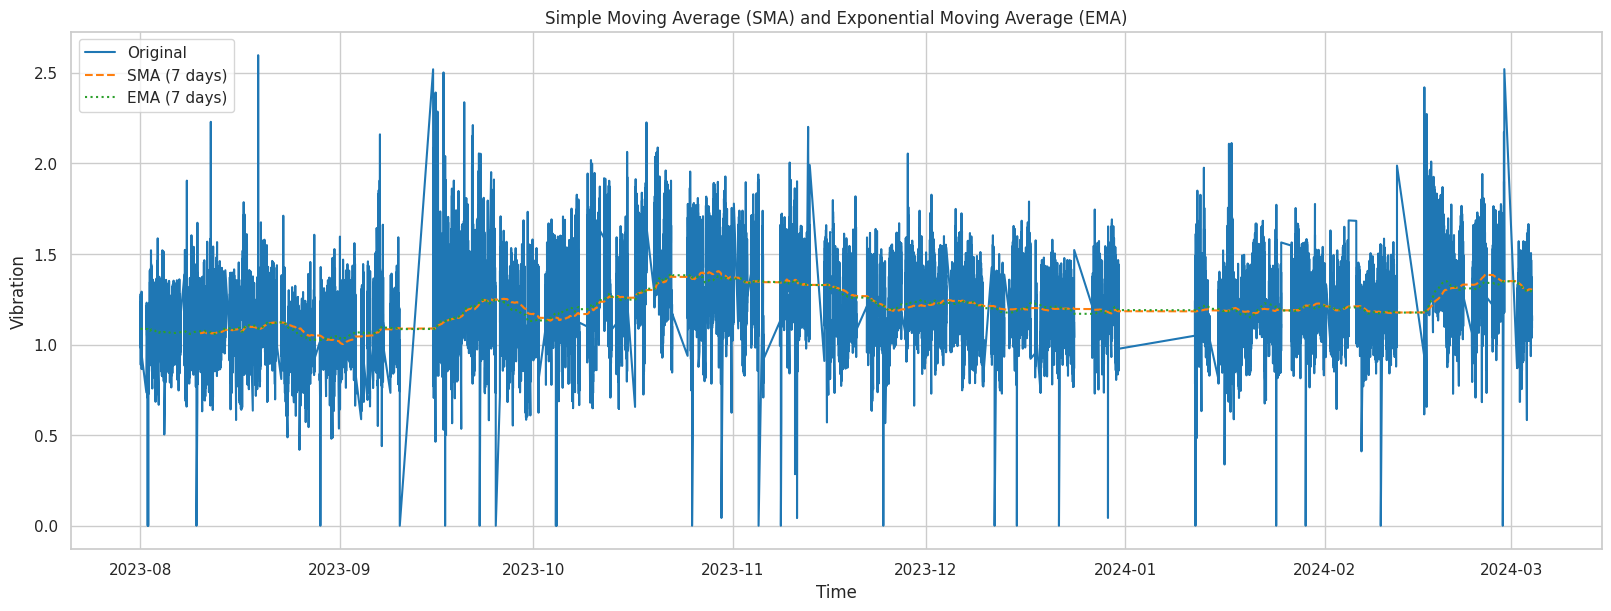

In [12]:
plot.sma_ema()

#### **Principais Observações:**

1. **Tendência Geral:**
    A série original oscila em torno de uma média central próxima a 1.0.
    Tanto a SMA quanto a EMA indicam uma tendência estável no longo prazo, com variações sutis.

2. **Picos e Ruído:**
    Existem picos bem altos (valores > 2.5) em momentos específicos, que podem ser considerados anomalias ou flutuações extremas.
    Há também períodos com muitos valores baixos, sugerindo possíveis interrupções ou falhas no processo.

3. **Diferença entre SMA e EMA:**
    A EMA acompanha as oscilações da série original de forma mais próxima do que a SMA devido ao maior peso nos dados recentes.
    A SMA apresenta uma suavização mais "atrasada" e estável, o que é esperado.

/home/ezequiel/.cache/pypoetry/virtualenvs/vrm-lstm-XgRwfIx7-py3.13/lib/python3.13/site-packages/pywt/_cwt.py:117: FutureWarning: Wavelets from the family cmor, without parameters specified in the name are deprecated. The name should follow the format cmorB-C, where B and C are floats representing the bandwidth frequency and center frequency, respectively (example, for backward compatibility: cmor = cmor1.0-0.5).
  wavelet = DiscreteContinuousWavelet(wavelet)


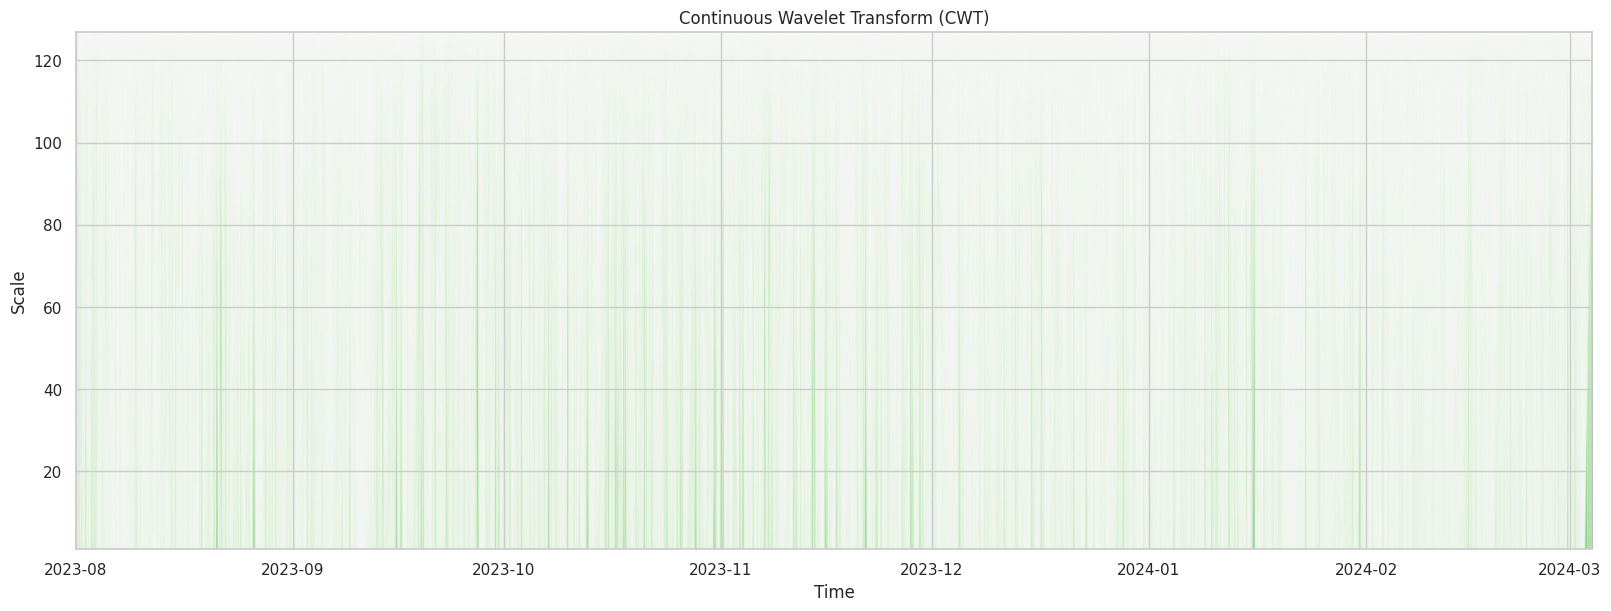

In [13]:
plot.wavelet_transform()